<a href="https://colab.research.google.com/github/Jonny-T87/ML-Projects/blob/main/SVMCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import scipy.optimize as opt
import matplotlib.pyplot as plyv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import f1_score, jaccard_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import itertools
%matplotlib inline

In [2]:
# Loadin data
!wget -O cell_samples.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv

df = pd.read_csv("cell_samples.csv")
df.head()

--2024-06-26 02:42:28--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20675 (20K) [text/csv]
Saving to: ‘cell_samples.csv’

cell_samples.csv    100%[===================>]  20.19K  --.-KB/s    in 0.02s   

2024-06-26 02:42:29 (1006 KB/s) - ‘cell_samples.csv’ saved [20675/20675]



,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
#checking data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           699 non-null    int64 
 1   Clump        699 non-null    int64 
 2   UnifSize     699 non-null    int64 
 3   UnifShape    699 non-null    int64 
 4   MargAdh      699 non-null    int64 
 5   SingEpiSize  699 non-null    int64 
 6   BareNuc      699 non-null    object
 7   BlandChrom   699 non-null    int64 
 8   NormNucl     699 non-null    int64 
 9   Mit          699 non-null    int64 
 10  Class        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [16]:
#checking data stats
df.describe()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BlandChrom,NormNucl,Mit,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


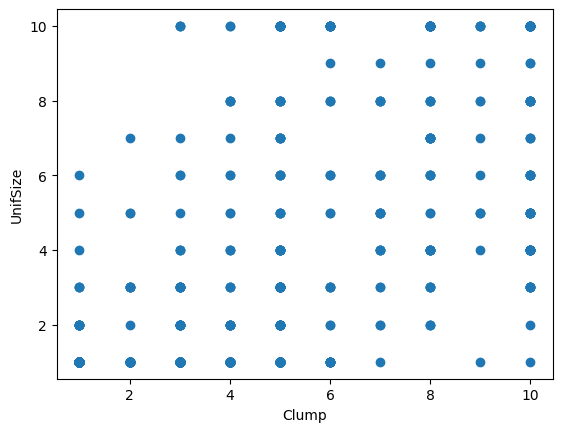

In [17]:
#scatter plot of clump vs unifsize
plyv.scatter(df.Clump, df.UnifSize)
plyv.xlabel("Clump")
plyv.ylabel("UnifSize")
plyv.show()

In [26]:
#Cleaning by drop na or text and changing to int in BareNuc
df = df[pd.to_numeric(df['BareNuc'], errors='coerce').notnull()]
df['BareNuc'] = df['BareNuc'].astype('int')
df.head()

<ipython-input-26-42d475f9045f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BareNuc'] = df['BareNuc'].astype('int')


,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [27]:
#Checking data
df.BareNuc.value_counts()

BareNuc
1     402
10    132
2      30
5      30
3      28
8      21
4      19
9       9
7       8
6       4
Name: count, dtype: int64

In [31]:
#Making features for model
X = np.asarray(df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']])
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]])

In [30]:
#making target for model
y = np.asarray(df['Class'])
y[0:5]

array([2, 2, 2, 2, 2])

In [33]:
#train test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [34]:
#checking train and test data shape
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


In [41]:
#Creating svm model with rbf function and fitting to data
clf = svm.SVC(kernel='rbf', random_state=4)
clf.fit(X_train, y_train)

SVC(random_state=4)

In [42]:
#taking look at model parameters
clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 4,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [44]:
#using model to predict
yhat = clf.predict(X_test)
yhat[0:5]

array([2, 4, 2, 4, 2])

In [51]:
#Computing confusion matrix on rbf model
rbf_cfm = confusion_matrix(y_test, yhat, labels=[2,4])
rbf_cfm

array([[85,  5],
       [ 0, 47]])

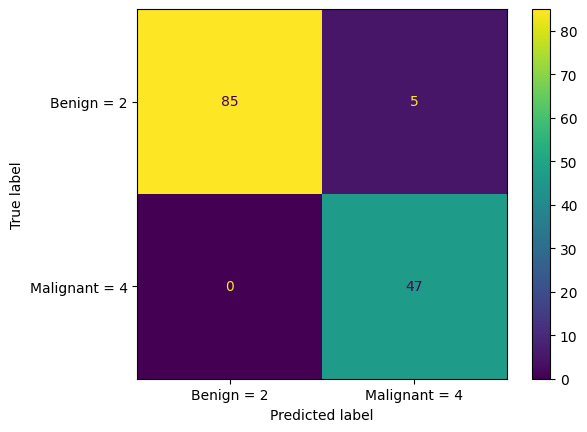

In [60]:
#Displaying ConfusionMatrix
disp = ConfusionMatrixDisplay(confusion_matrix=rbf_cfm, display_labels=['Benign = 2','Malignant = 4'])
disp.plot()
plyv.show()

In [62]:
#printing Confusion scores
np.set_printoptions(precision=2)
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137



In [64]:
#F1 Score for model is excelent with 96.3%
f1_score(y_test, yhat, average='weighted')

0.9639038982104676

In [70]:
#verifying f1score with jacard score, they are close
jaccard_score(y_test, yhat, labels=[2,4], pos_label=4)

0.9038461538461539